In [1]:
# necessary packages #
#cd("./Documents/Github/Multi_NNGP/RDA/projects/Conj/")

using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using DataFrames
using Dates

In [2]:
# Packages for diagnostic test #

using StatsPlots
using MCMCChains
using PrettyTables

In [3]:
@load "../../results/conj/Multi_conj_latent_data.jld" 

19-element Array{Symbol,1}:
 :p                
 :q                
 :N_sam            
 :Y_ord            
 :β_sam            
 :Σ_sam            
 :cov_ω_sam        
 :ω_sam_mean       
 :ω_sam_var        
 :ω_incp_sam_mean  
 :ω_incp_sam_var   
 :ω_M_sam_mean     
 :ω_M_sam_var      
 :ω_incp_M_sam_mean
 :ω_incp_M_sam_var 
 :Y_M_sam_mean     
 :Y_M_sam_var      
 :ϕ_pick           
 :α_pick           

In [4]:
Sys.free_memory()/(2^20*1024)

15.55413818359375

In [5]:
@load "../../data/conj_data/conj_data_expanded.jld"

┌ Warning: type OrderedCollections.OrderedDict{Symbol,Any} does not exist in workspace; reconstructing
└ @ JLD2 /home/lu/.julia/packages/JLD2/KjBIK/src/data.jl:1153


24-element Array{Symbol,1}:
 :U_indx      
 :S_indx      
 :N           
 :n           
 :m           
 :NN          
 :nnIndx_col  
 :nnIndx_row  
 :NM          
 :MnnIndxLU   
 :MnnIndx     
 :Mnndists    
 :coords      
 :coords_pred 
 :CVNN_train  
 :CVnnIndx_col
 :CVnnIndx_row
 :CVNN_test   
 :CVMnnIndxLU 
 :CVMnnIndx   
 :CVMnndists  
 :parts_train 
 :parts_test  
 :kf          

In [6]:
N

3115934

In [7]:
NM

67132

# MCMC Chain check

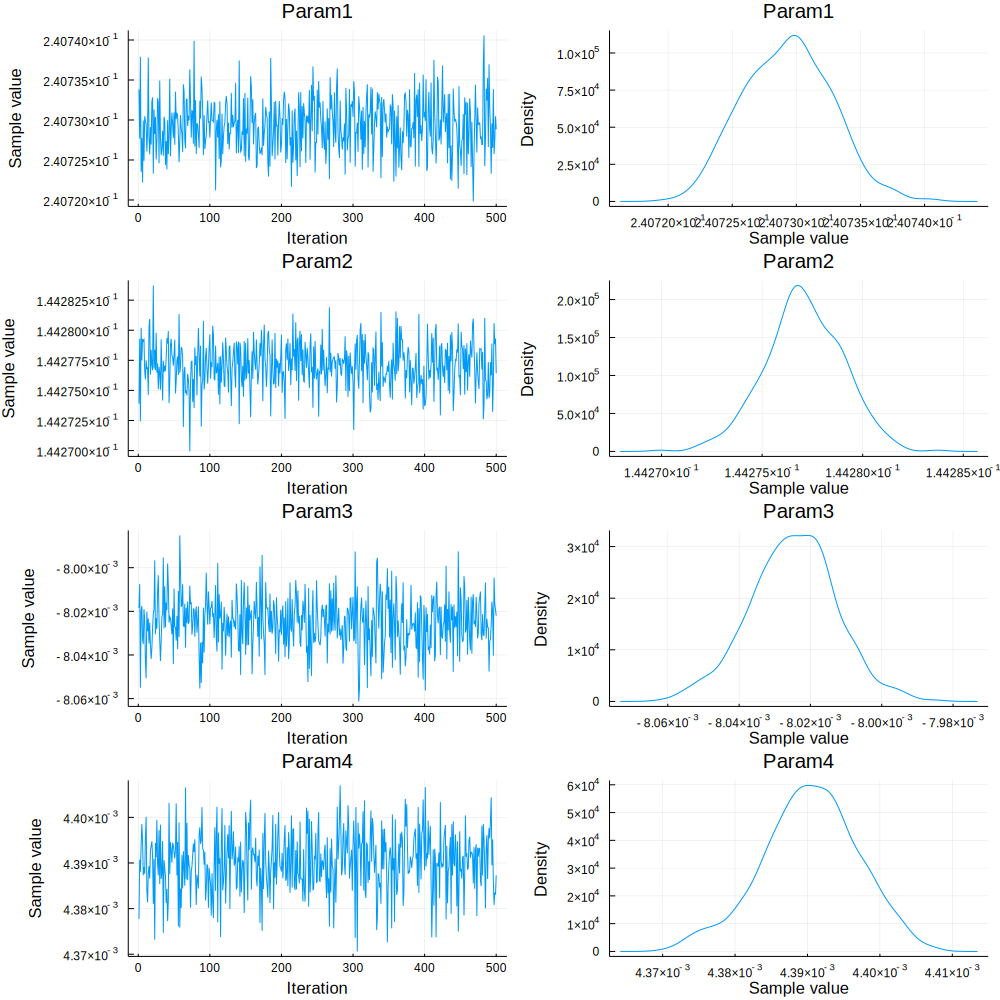

In [8]:
β_pos_sam = Array{Float64, 3}(undef, N_sam, p * q, 1);
β_pos_sam[:, :, 1] = hcat(β_sam[1, 1, :], β_sam[1, 2, :], 
    β_sam[2, 1, :], β_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

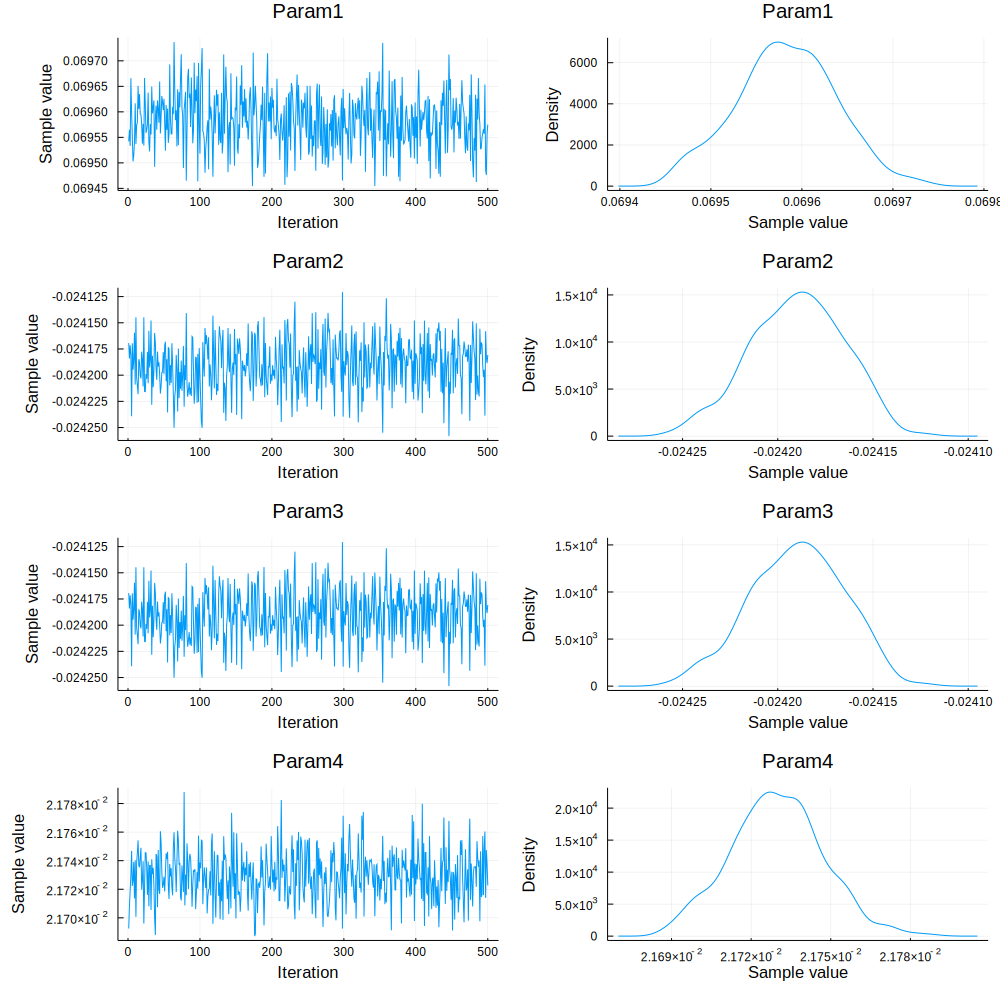

In [9]:
truncindex = 1; #Integer(trunc(N_sam / 2));
Σ_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, truncindex:N_sam], Σ_sam[1, 2, truncindex:N_sam], 
    Σ_sam[2, 1, truncindex:N_sam], Σ_sam[2, 2, truncindex:N_sam]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

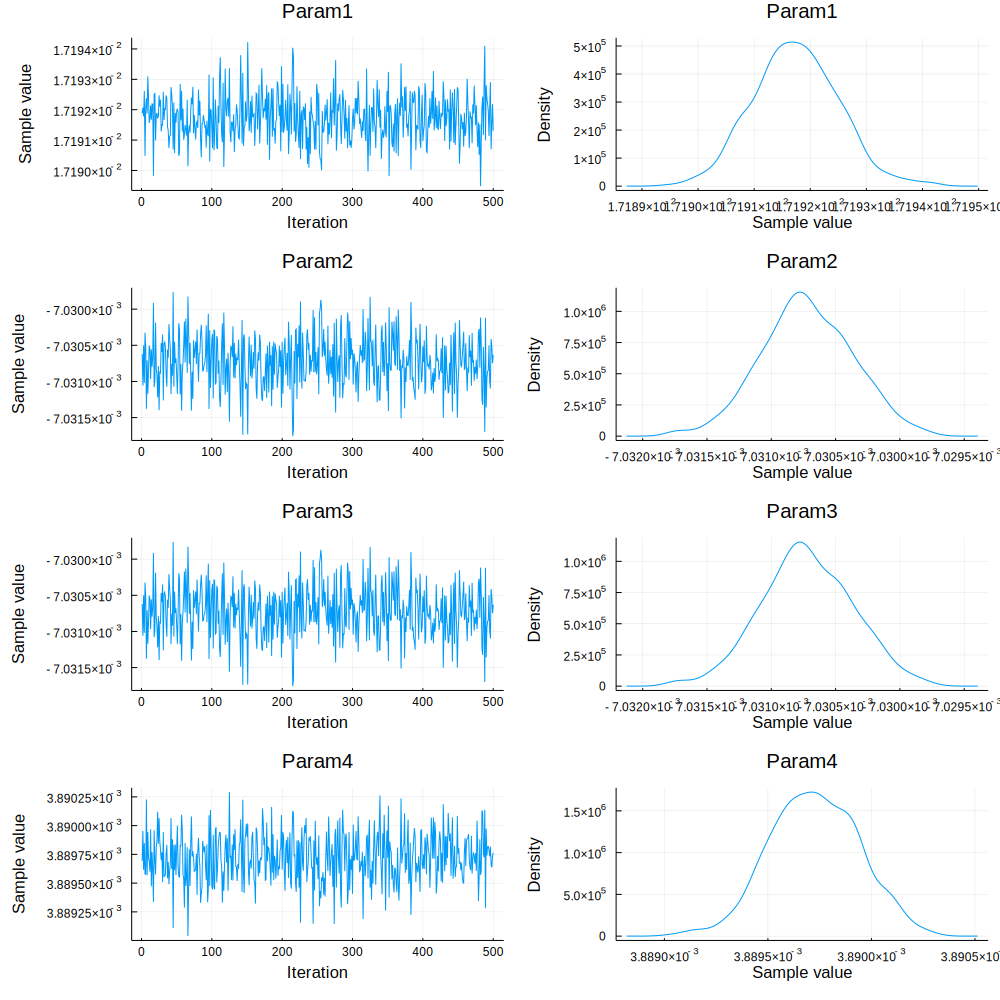

In [10]:
# check the variance covariance across latent process
# ω_incp_obs_pos_sam[:, :, i]
cov_pos_sam = Array{Float64, 3}(undef, N_sam, q * q, 1);
cov_pos_sam[:, :, 1] = hcat(cov_ω_sam[1, 1, :], cov_ω_sam[1, 2, :], 
    cov_ω_sam[2, 1, :], cov_ω_sam[2, 2, :]);
cov_pos_chain = Chains(cov_pos_sam);
pcov = plot(cov_pos_chain)

# Posterior Inference 

In [11]:
# posterior prediction check #
N_Inf_burn = 1;
count_Y_M = fill(0.0, q);
for j in 1:q
    for i in 1:NM
        count_Y_M[j] = count_Y_M[j] + 
        (((Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) < Y_ord[U_indx[i], j]) && 
            ((Y_M_sam_mean[i, j] + 1.96 * sqrt(Y_M_sam_var[i, j])) > Y_ord[U_indx[i], j]))
    end
end
count_Y_M

2-element Array{Float64,1}:
 65549.0
 65218.0

In [12]:
round.(count_Y_M ./ NM, digits = 4)

2-element Array{Float64,1}:
 0.9764
 0.9715

In [13]:
round(sum(count_Y_M) / (q * NM), digits = 4)

0.974

In [14]:
# calculate root mean square predictive error #
MSPE1 = mean((Y_ord[U_indx, 1] - Y_M_sam_mean[:, 1]).^2)
RMSPE1 = sqrt(MSPE1); RMSPE1

0.05030062261483353

In [15]:
MSPE2 = mean((Y_ord[U_indx, 2] - Y_M_sam_mean[:, 2]).^2)
RMSPE2 = sqrt(MSPE2); RMSPE2

0.025723546214639535

In [16]:
# calculate root mean square predictive error #
MSPE = mean((Y_ord[U_indx, :] - Y_M_sam_mean).^2)
RMSPE = sqrt(MSPE); RMSPE

0.03994905171150248

In [17]:
round.([RMSPE1 RMSPE2 RMSPE], digits = 5)

1×3 Array{Float64,2}:
 0.0503  0.02572  0.03995

In [18]:
# calculate root mean square predictive error #
MAE1 = mean(abs.(Y_ord[U_indx, 1] - Y_M_sam_mean[:, 1]))
MAE2 = mean(abs.(Y_ord[U_indx, 2] - Y_M_sam_mean[:, 2]))
MAE = mean(abs.(Y_ord[U_indx, :] - Y_M_sam_mean))
round.([MAE1 MAE2 MAE], digits = 5)

1×3 Array{Float64,2}:
 0.03192  0.01775  0.02484

In [19]:
# CRPS
CRPS = [(sqrt(Y_M_sam_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) -
        ((Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[U_indx[i], j] - Y_M_sam_mean[i, j]) / sqrt(Y_M_sam_var[i, j])) - 1 )))
        for i in 1:NM, j in 1:q];
round.([mean(CRPS[:, 1]) mean(CRPS[:, 2]) mean(CRPS)], digits = 5)

1×3 Array{Float64,2}:
 -0.0314  -0.01748  -0.02444

In [20]:
#INT 
Y_m_pos_L = [(Y_M_sam_mean[i, j] - 1.96 * sqrt(Y_M_sam_var[i, j])) for i in 1:NM, j in 1:q];
Y_m_pos_U = [(Y_M_sam_mean[i, j] + 1.96 * sqrt(Y_M_sam_var[i, j])) for i in 1:NM, j in 1:q];
INT = [(( 1.96 * 2 * sqrt(Y_M_sam_var[i, j])) + 
    (2 / 0.05)*(Y_m_pos_L[i, j] - Y_ord[U_indx[i], j]) * (Y_ord[U_indx[i], j] < Y_m_pos_L[i, j]) + 
    (2 / 0.05)*(Y_ord[U_indx[i], j] - Y_m_pos_U[i, j]) * (Y_ord[U_indx[i], j] > Y_m_pos_U[i, j]))
    for i in 1: NM, j in 1:q];
round.([mean(INT[:, 1]) mean(INT[:, 2]) mean(INT)], digits = 5)

1×3 Array{Float64,2}:
 0.42704  0.23435  0.3307

In [21]:
N_Inf_burn = 1;
summary_table = Array{Float64, 2}(undef, 10, 4);
summary_table[1, :] = vcat(mean(β_sam[1, 1, N_Inf_burn:N_sam]),
    quantile(β_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(mean(β_sam[1, 2, N_Inf_burn:N_sam]),
    quantile(β_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(mean(β_sam[2, 1, N_Inf_burn:N_sam]),
    quantile(β_sam[2, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(mean(β_sam[2, 2, N_Inf_burn:N_sam]),
    quantile(β_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat(mean((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(mean((1 / α_pick - 1.0) .* Σ_sam[1, 2, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(mean((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat(mean(cov_ω_sam[1, 1, :]),
    quantile(cov_ω_sam[1, 1, :], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat( mean(cov_ω_sam[2, 1, :]),
    quantile(cov_ω_sam[2, 1, :], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat(mean(cov_ω_sam[2, 2, :]),
    quantile(cov_ω_sam[2, 2, :], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 7);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "(1/α - 1)Σ[1, 1]", "(1/α - 1)Σ[2, 2]", 
    "(1/α - 1)Σ[2, 1]", "var(ω1)",  "cov(ω1, ω2)", "var(ω2)"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "mean" "median" "2.5%" "97.5%"], markdown)

|                  |       mean |     median |       2.5% |      97.5% |
|------------------|------------|------------|------------|------------|
|          β[1, 1] |  0.2407293 |  0.2407294 |   0.240723 |  0.2407361 |
|          β[1, 2] |  0.1442771 |   0.144277 |  0.1442732 |  0.1442806 |
|          β[2, 1] | -0.0080249 | -0.0080248 | -0.0080497 | -0.0080008 |
|          β[2, 2] |  0.0043903 |  0.0043905 |  0.0043758 |  0.0044025 |
| (1/α - 1)Σ[1, 1] |    3.13e-5 |    3.13e-5 |    3.12e-5 |    3.13e-5 |
| (1/α - 1)Σ[2, 2] |   -1.09e-5 |   -1.09e-5 |   -1.09e-5 |   -1.08e-5 |
| (1/α - 1)Σ[2, 1] |     9.8e-6 |     9.8e-6 |     9.7e-6 |     9.8e-6 |
|          var(ω1) |  0.0171917 |  0.0171917 |  0.0171903 |  0.0171933 |
|      cov(ω1, ω2) | -0.0070307 | -0.0070307 | -0.0070314 |   -0.00703 |
|          var(ω2) |  0.0038897 |  0.0038897 |  0.0038893 |  0.0038901 |


In [22]:
ϕ_pick

20.175501251534527

In [23]:
α_pick

0.999551052631579

In [24]:
# choose 33 36 34 35 #
(1616.943263 + 1426.386516 + 7987.061007 + 5186.429565) /60 

270.28033918333335

In [25]:
(18*60 + 53) / 60

18.883333333333333

# plot maps

In [26]:
using RData
@time data_cleaned = load("../../data/rawdata/cleaned_data2_expanded.RData", convert = true)["data_cleaned2"];

 13.261950 seconds (30.10 M allocations: 2.807 GiB, 18.37% gc time)


In [27]:
coords_xy = hcat((round.((data_cleaned.x[S_indx] .- 329) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 329),
    (round.((data_cleaned.y[S_indx] .- 168) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 168));
coords_xy_pred = hcat((round.((data_cleaned.x[U_indx] .- 329) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 329),
    (round.((data_cleaned.y[U_indx] .- 168) ./ (463 * 8); digits = 0) .*(463 * 8) .+ 168));
ω_incp_fit = vcat(ω_incp_sam_mean, ω_incp_M_sam_mean); coords_xy_ω = vcat(coords_xy, coords_xy_pred);
Y_fit = vcat(copy(Y_ord[S_indx, :]), Y_M_sam_mean); 

In [28]:
@load "../../results/conj/conj_resp_results.jld" # load the data of conjugate model

13-element Array{Symbol,1}:
 :N_sam       
 :NM          
 :p           
 :q           
 :β_sam       
 :Σ_sam       
 :Y_m_pos_qt  
 :Y_m_pos_mean
 :Y_m_pos_var 
 :U_indx      
 :Y_ord       
 :α_pick      
 :ϕ_pick      

In [30]:
Y_fit_resp = vcat(copy(Y_ord[S_indx, :]), Y_m_pos_mean); 

In [31]:
# check the plot of the data 
using RCall
@rput Y_ord
@rput S_indx U_indx
@rput coords_xy
@rput coords_xy_ω
@rput ω_incp_fit
@rput Y_fit Y_fit_resp
R"""
library(MBA)
library(classInt)
library(RColorBrewer)
library(sp)
library(coda)
library(spBayes)
library(fields)
library(rworldmap)
library(rworldxtra)
library(raster)
library(leaflet)

raw1.data <- data.frame(x = coords_xy[, 1], y = coords_xy[, 2], z =  Y_ord[S_indx, 1])
raw2.data <- data.frame(x = coords_xy[, 1], y = coords_xy[, 2], z =  Y_ord[S_indx, 2])
raw1_nomiss.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z =  Y_ord[c(S_indx, U_indx), 1])
raw2_nomiss.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z =  Y_ord[c(S_indx, U_indx), 2])
fit_y1.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = Y_fit[, 1])
fit_y2.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = Y_fit[, 2])
fit_y1_resp.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = Y_fit_resp[, 1])
fit_y2_resp.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = Y_fit_resp[, 2])
fit_incpw1.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = ω_incp_fit[, 1])
fit_incpw2.data <- data.frame(x = coords_xy_ω[, 1], y = coords_xy_ω[, 2], z = ω_incp_fit[, 2])

coordinates(raw1.data) = ~x+y
gridded(raw1.data) = TRUE
raw1.data = as(raw1.data, "SpatialGridDataFrame")
projection(raw1.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(raw2.data) = ~x+y
gridded(raw2.data) = TRUE
raw2.data = as(raw2.data, "SpatialGridDataFrame")
projection(raw2.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(raw1_nomiss.data) = ~x+y
gridded(raw1_nomiss.data) = TRUE
raw1_nomiss.data = as(raw1_nomiss.data, "SpatialGridDataFrame")
projection(raw1_nomiss.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(raw2_nomiss.data) = ~x+y
gridded(raw2_nomiss.data) = TRUE
raw2_nomiss.data = as(raw2_nomiss.data, "SpatialGridDataFrame")
projection(raw2_nomiss.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_y1.data) = ~x+y
gridded(fit_y1.data) = TRUE
fit_y1.data = as(fit_y1.data, "SpatialGridDataFrame")
projection(fit_y1.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_y2.data) = ~x+y
gridded(fit_y2.data) = TRUE
fit_y2.data = as(fit_y2.data, "SpatialGridDataFrame")
projection(fit_y2.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_y1_resp.data) = ~x+y
gridded(fit_y1_resp.data) = TRUE
fit_y1_resp.data = as(fit_y1_resp.data, "SpatialGridDataFrame")
projection(fit_y1_resp.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_y2_resp.data) = ~x+y
gridded(fit_y2_resp.data) = TRUE
fit_y2_resp.data = as(fit_y2_resp.data, "SpatialGridDataFrame")
projection(fit_y2_resp.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"


coordinates(fit_incpw1.data) = ~x+y
gridded(fit_incpw1.data) = TRUE
fit_incpw1.data = as(fit_incpw1.data, "SpatialGridDataFrame")
projection(fit_incpw1.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

coordinates(fit_incpw2.data) = ~x+y
gridded(fit_incpw2.data) = TRUE
fit_incpw2.data = as(fit_incpw2.data, "SpatialGridDataFrame")
projection(fit_incpw2.data) <- "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"



data <- c(raw1_nomiss.data$z, raw2_nomiss.data$z)
#, fit_y1.data$z, fit_y2.data$z, fit_incpw1.data$z, fit_incpw2.data$z)
surf.brks <- classIntervals(data[!is.na(data)], 500, 'pretty')$brks
col.pal <- colorRampPalette(brewer.pal(11,'RdBu')[11:1])
xlim <- c(range(coords_xy_ω[, 1])[1], range(coords_xy_ω[, 1])[2] + 
            0.13*(range(coords_xy_ω[, 1])[2] - range(coords_xy_ω[, 1])[1])) ;


zlim <- range(data[!is.na(data)])

# size for the mapping of w               
width <- 360*1.2
height <- 360
pointsize <- 16


png(paste("../../pics/conj_latent_map-raw1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw1.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/conj_latent_map-raw2.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw2.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/conj_latent_map-raw1_nomiss.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw1_nomiss.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/conj_latent_map-raw2_nomiss.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- raw2_nomiss.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()


png(paste("../../pics/conj_latent_map-fit1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_y1.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/conj_latent_map-fit2.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_y2.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/conj_resp_map-fit1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_y1_resp.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/conj_resp_map-fit2.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_y2_resp.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()


png(paste("../../pics/conj_latent_map-incpw1.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_incpw1.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

png(paste("../../pics/conj_latent_map-incpw2.png", sep = ""), 
    width = width, height = height, pointsize = pointsize, family = "Courier")
par(mfrow = c(1, 1))
##Obs
i <- fit_incpw2.data
plot(coords_xy_ω, typ="n", cex=0.5, xlim=xlim, axes=FALSE, ylab="y", xlab="x") 
     #main = "true")
axis(2, las=1)
axis(1)
plot(i, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
#image.plot(i, add=TRUE, col=rev(col.pal(length(surf.brks)-1)), zlim=zlim)
dev.off()

"""

┌ Warning: RCall.jl: Loading required package: magic
│ Loading required package: abind
│ Loading required package: Formula
│ Loading required package: Matrix
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:113
┌ Warning: RCall.jl: Loading required package: spam
│ Loading required package: dotCall64
│ Loading required package: grid
│ Spam version 2.2-2 (2019-03-07) is loaded.
│ Type 'help( Spam)' or 'demo( spam)' for a short introduction 
│ and overview of this package.
│ Help for individual functions is also obtained by adding the
│ suffix '.spam' to the function name, e.g. 'help( chol.spam)'.
│ 
│ Attaching package: ‘spam’
│ 
│ The following object is masked from ‘package:Matrix’:
│ 
│     det
│ 
│ The following objects are masked from ‘package:base’:
│ 
│     backsolve, forwardsolve
│ 
│ Loading required package: maps
│ See https://github.com/NCAR/Fields for
│  an extensive vignette, other supplements and source code 
└ @ RCall /home/lu/.julia/packages/RCall/g7dhB/src/io.jl:

RObject{IntSxp}
null device 
          1 
